In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
# Load data
df = pd.read_excel('ML_LC_DEST_Refined_V1.xlsx')

# Keep only visible columns
visible_columns = [
    'TRAIN_ID', 'STN_333', 'STN_ST', 'STN_TYPE_CD', 'STN_SEQ_NBR',
    'crew_order', 'DPT_DIR', 'REQ_INSP', 'TA', 'TD',
    'DESTINATION', 'ArrivalDestination', 'LAST_CREW_STATION', 'DWELL_TIME'
]
df = df[visible_columns]
df.shape

(693, 14)

In [ ]:
# Quick overview
df.head()

,TRAIN_ID,STN_333,STN_ST,STN_TYPE_CD,STN_SEQ_NBR,crew_order,DPT_DIR,REQ_INSP,TA,TD,DESTINATION,ArrivalDestination,LAST_CREW_STATION,DWELL_TIME
0,XBERBSB928H2021-05-28,MINOT,ND,C,40,1,E,N,2021-05-30T05:04:00-05:00,2021-05-30T05:22:00-05:00,BISBEE,2021-05-30T11:07:00-05:00,MINOT,0.30
1,XKAHKND911H2024-08-11,MINOT,ND,C,50,1,E,N,2024-08-12T04:18:00-05:00,2024-08-12T07:43:00-05:00,CASSELTON,2024-08-12T16:07:00-05:00,MINOT,3.42
2,XCROBSB921A2023-09-21,MINOT,ND,C,90,1,E,N,2023-09-21T19:53:00-05:00,2023-09-21T20:49:00-05:00,BISBEE,2023-09-22T02:34:00-05:00,MINOT,0.93
3,XCROEGE922A2023-09-22,MINOT,ND,C,90,1,E,N,2023-09-22T18:36:00-05:00,2023-09-22T19:37:00-05:00,CASSELTON,2023-09-23T01:07:00-05:00,MINOT,1.02
4,XCROHBG919A2023-09-19,MINOT,ND,C,90,1,E,N,2023-09-19T16:21:00-05:00,2023-09-19T17:45:00-05:00,HAMBERG,2023-09-19T19:30:00-05:00,MINOT,1.40


In [ ]:
# Data quality check
df.isnull().sum().sum()  # 0 missing values
df.duplicated().sum()     # 0 duplicates

np.int64(0)

In [ ]:
# Identify columns with only one unique value
single_value_columns = df.columns[df.nunique() == 1].tolist()
print(f"Columns with single unique value ({len(single_value_columns)}): {single_value_columns}")

Columns with single unique value (6): ['STN_333', 'STN_ST', 'STN_TYPE_CD', 'crew_order', 'DPT_DIR', 'LAST_CREW_STATION']


In [ ]:
# These columns won't help in understanding patterns or relationships in the data
# Remove columns with only one unique value
df_clean = df.drop(columns=single_value_columns)
df_clean.shape
df_clean.head()

,TRAIN_ID,STN_SEQ_NBR,REQ_INSP,TA,TD,DESTINATION,ArrivalDestination,DWELL_TIME
0,XBERBSB928H2021-05-28,40,N,2021-05-30T05:04:00-05:00,2021-05-30T05:22:00-05:00,BISBEE,2021-05-30T11:07:00-05:00,0.30
1,XKAHKND911H2024-08-11,50,N,2024-08-12T04:18:00-05:00,2024-08-12T07:43:00-05:00,CASSELTON,2024-08-12T16:07:00-05:00,3.42
2,XCROBSB921A2023-09-21,90,N,2023-09-21T19:53:00-05:00,2023-09-21T20:49:00-05:00,BISBEE,2023-09-22T02:34:00-05:00,0.93
3,XCROEGE922A2023-09-22,90,N,2023-09-22T18:36:00-05:00,2023-09-22T19:37:00-05:00,CASSELTON,2023-09-23T01:07:00-05:00,1.02
4,XCROHBG919A2023-09-19,90,N,2023-09-19T16:21:00-05:00,2023-09-19T17:45:00-05:00,HAMBERG,2023-09-19T19:30:00-05:00,1.40


In [ ]:
# Parse date columns from strings to datetime objects for proper temporal analysis
df_clean['TA'] = pd.to_datetime(df_clean['TA'], utc=True)
df_clean['TD'] = pd.to_datetime(df_clean['TD'], utc=True)
df_clean['ArrivalDestination'] = pd.to_datetime(df_clean['ArrivalDestination'], utc=True)

print(df_clean['TA'].unique())

<DatetimeArray>
['2021-05-30 10:04:00+00:00', '2024-08-12 09:18:00+00:00',
 '2023-09-22 00:53:00+00:00', '2023-09-22 23:36:00+00:00',
 '2023-09-19 21:21:00+00:00', '2021-09-25 20:49:00+00:00',
 '2021-09-21 01:41:00+00:00', '2021-10-01 03:45:00+00:00',
 '2021-10-02 01:05:00+00:00', '2021-10-04 23:00:00+00:00',
 ...
 '2020-11-15 12:00:00+00:00', '2023-07-26 23:19:00+00:00',
 '2021-10-10 08:20:00+00:00', '2021-04-08 08:26:00+00:00',
 '2022-03-09 19:57:00+00:00', '2021-09-09 11:22:00+00:00',
 '2024-08-11 01:45:00+00:00', '2021-04-03 01:27:00+00:00',
 '2020-11-29 09:44:00+00:00', '2021-03-09 10:14:00+00:00']
Length: 693, dtype: datetime64[ns, UTC]


In [ ]:
# Check column data types to confirm successful datetime conversion
df_clean.dtypes

TRAIN_ID                           object
STN_SEQ_NBR                         int64
REQ_INSP                           object
TA                    datetime64[ns, UTC]
TD                    datetime64[ns, UTC]
DESTINATION                        object
ArrivalDestination    datetime64[ns, UTC]
DWELL_TIME                        float64
dtype: object

In [ ]:
# Explore categorical variables to understand their possible values and distribution
categorical_cols = ['REQ_INSP', 'DESTINATION']
for col in categorical_cols:
    print(f"\n{col}: {df_clean[col].nunique()} values")
    print(df_clean[col].value_counts())


REQ_INSP: 6 values
REQ_INSP
N    528
C    110
X     32
Q     19
V      3
Z      1
Name: count, dtype: int64

DESTINATION: 5 values
DESTINATION
CASSELTON    337
BISBEE       103
HAMBERG       90
PILLSBURY     84
FARGO         79
Name: count, dtype: int64


In [ ]:
# Create a binary inspection flag column: 'N' remains 'N', all other codes become 'Y'
df_clean['INSPECTION_REQUIRED'] = df_clean['REQ_INSP'].apply(lambda x: 'N' if x == 'N' else 'Y')

Inspection Requirement Distribution:
Trains requiring inspection (Y): 165 trains
Trains NOT requiring inspection (N): 528 trains


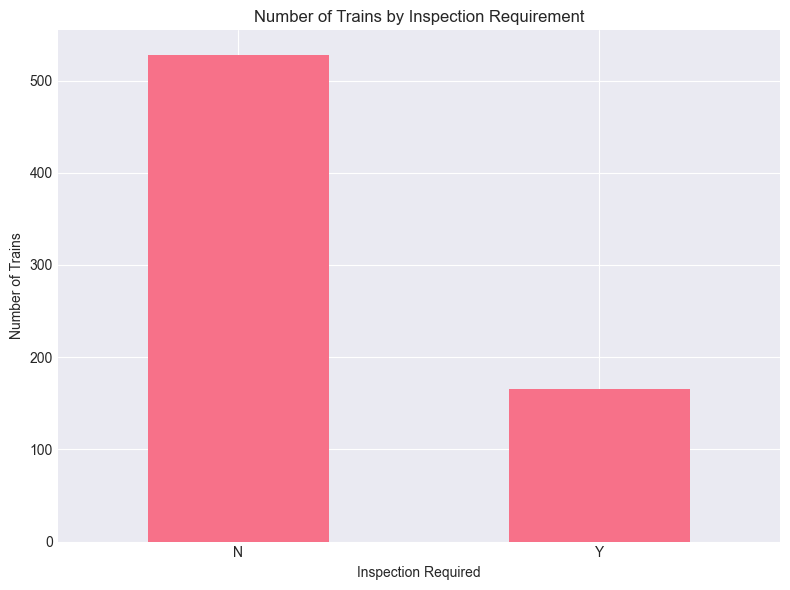

In [ ]:
# Visualize the distribution of inspection requirements (Y/N)
# This shows the proportion of trains requiring inspection vs those that don't

# Get the counts
inspection_counts = df_clean['INSPECTION_REQUIRED'].value_counts()

# Print the figures
print("Inspection Requirement Distribution:")
print(f"Trains requiring inspection (Y): {inspection_counts.get('Y', 0)} trains")
print(f"Trains NOT requiring inspection (N): {inspection_counts.get('N', 0)} trains")

# Create bar plot with default matplotlib colors
plt.figure(figsize=(8, 6))
inspection_counts.plot(kind='bar')
plt.title('Number of Trains by Inspection Requirement')
plt.xlabel('Inspection Required')
plt.ylabel('Number of Trains')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Analyze the station sequence numbers to understand where Minot falls in different train routes
# STN_SEQ_NBR indicates Minot's position in the overall route (e.g., 40 means Minot is the 40th station)
print(f"STN_SEQ_NBR Analysis:")
print(f"Number of different positions where Minot appears in routes: {df_clean['STN_SEQ_NBR'].nunique()}")
print(f"Range: {df_clean['STN_SEQ_NBR'].min()} - {df_clean['STN_SEQ_NBR'].max()}")


STN_SEQ_NBR Analysis:
Number of different positions where Minot appears in routes: 27
Range: 40 - 2460


Number of Trains by Destination:
CASSELTON: 337 trains
BISBEE: 103 trains
HAMBERG: 90 trains
PILLSBURY: 84 trains
FARGO: 79 trains

Total trains: 693


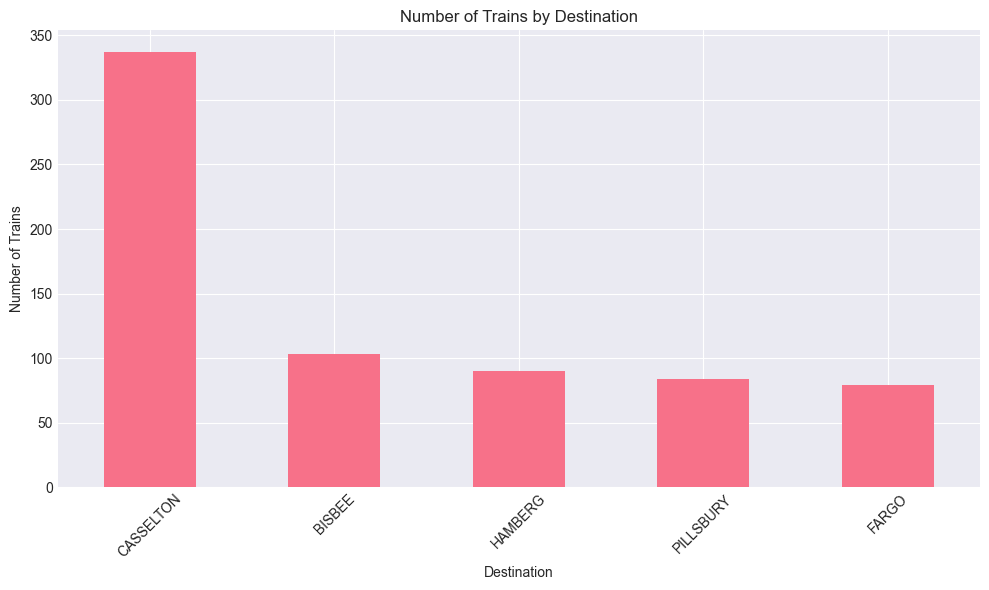

In [ ]:
# Analyze and visualize the distribution of trains by destination

# Get destination counts
destination_counts = df_clean['DESTINATION'].value_counts()

# Print the figures
print("Number of Trains by Destination:")
for dest, count in destination_counts.items():
    print(f"{dest}: {count} trains")
print(f"\nTotal trains: {destination_counts.sum()}")

# Visualize the distribution
plt.figure(figsize=(10, 6))
destination_counts.plot(kind='bar')
plt.title('Number of Trains by Destination')
plt.xlabel('Destination')
plt.ylabel('Number of Trains')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

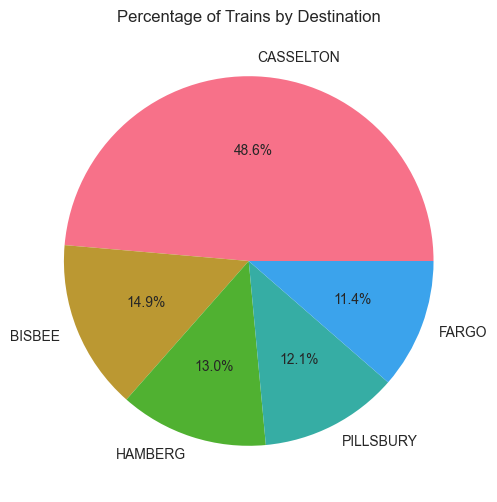

In [ ]:
# Visualize the proportion of trains going to each destination in a pie chart

plt.figure(figsize=(8, 6))
df_clean['DESTINATION'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Percentage of Trains by Destination')
plt.ylabel('')
plt.show()

In [ ]:
# Get basic statistics for dwell time (average, min, max, etc.)
df_clean['DWELL_TIME'].describe()

count   693.00
mean      4.23
std       8.29
min       0.30
25%       1.13
50%       2.30
75%       4.90
max     137.00
Name: DWELL_TIME, dtype: float64

In [ ]:
# Break down dwell time into ranges to see how many trains fall into each category
# This gives more detail than just the average
print("DWELL_TIME Distribution Analysis:")
print(f"< 5 hours: {len(df_clean[df_clean['DWELL_TIME'] < 5])} trains ({len(df_clean[df_clean['DWELL_TIME'] < 5])/len(df_clean)*100:.1f}%)")
print(f"5-10 hours: {len(df_clean[(df_clean['DWELL_TIME'] >= 5) & (df_clean['DWELL_TIME'] < 10)])} trains")
print(f"10-20 hours: {len(df_clean[(df_clean['DWELL_TIME'] >= 10) & (df_clean['DWELL_TIME'] < 20)])} trains")
print(f"> 20 hours: {len(df_clean[df_clean['DWELL_TIME'] >= 20])} trains")

DWELL_TIME Distribution Analysis:
< 5 hours: 525 trains (75.8%)
5-10 hours: 114 trains
10-20 hours: 43 trains
> 20 hours: 11 trains


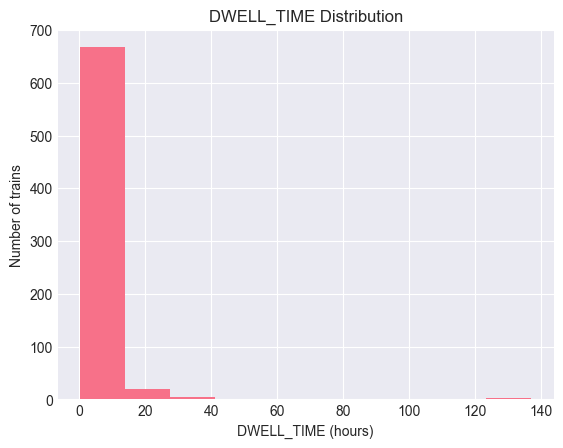

In [ ]:
# Visualize dwell time distribution with a histogram
df_clean['DWELL_TIME'].hist(bins=10)
plt.title('DWELL_TIME Distribution')
plt.xlabel('DWELL_TIME (hours)')
plt.ylabel('Number of trains')
plt.show()

In [ ]:
# Now I want to understand how dwell time varies by destination

# Create statistics table
dwell_summary = df_clean.groupby('DESTINATION')['DWELL_TIME'].agg([
    ('Nb of Trains', 'count'),
    ('Mean (h)', 'mean'),
    ('Median (h)', 'median'),
    ('Min (h)', 'min'),
    ('Max (h)', 'max'),
    ('Std (h)', 'std')
]).round(2)

# Sort by average dwell time for better insights
dwell_summary = dwell_summary.sort_values(by='Mean (h)', ascending=False)

print("DWELL TIME ANALYSIS BY DESTINATION")
print(dwell_summary)

DWELL TIME ANALYSIS BY DESTINATION
             Nb of Trains  Mean (h)  Median (h)  Min (h)  Max (h)  Std (h)
DESTINATION                                                               
BISBEE                103      5.93        2.72     0.30   137.00    14.17
CASSELTON             337      4.73        3.03     0.45   131.28     8.23
PILLSBURY              84      3.65        1.83     0.43    34.65     5.05
HAMBERG                90      2.76        1.82     0.42    10.97     2.53
FARGO                  79      2.21        1.37     0.58    19.45     2.92


In [ ]:
# Check how dwell times are distributed across different time ranges for each destination

print("\nDWELL TIME DISTRIBUTION BY DESTINATION")
print(f"{'Destination':<12} {'< 5 hrs':<15} {'5-10 hrs':<15} {'10-20 hrs':<15} {'> 20 hrs':<15}")
print("-"*70)

for dest in sorted(df_clean['DESTINATION'].unique()):
    dest_data = df_clean[df_clean['DESTINATION'] == dest]
    total = len(dest_data)

    less_5 = len(dest_data[dest_data['DWELL_TIME'] < 5])
    btw_5_10 = len(dest_data[(dest_data['DWELL_TIME'] >= 5) & (dest_data['DWELL_TIME'] < 10)])
    btw_10_20 = len(dest_data[(dest_data['DWELL_TIME'] >= 10) & (dest_data['DWELL_TIME'] < 20)])
    more_20 = len(dest_data[dest_data['DWELL_TIME'] >= 20])

    print(f"{dest:<12} {less_5:>3} ({less_5/total*100:>4.1f}%)    "
          f"{btw_5_10:>3} ({btw_5_10/total*100:>4.1f}%)    "
          f"{btw_10_20:>3} ({btw_10_20/total*100:>4.1f}%)    "
          f"{more_20:>3} ({more_20/total*100:>4.1f}%)")


DWELL TIME DISTRIBUTION BY DESTINATION
Destination  < 5 hrs         5-10 hrs        10-20 hrs       > 20 hrs       
----------------------------------------------------------------------
BISBEE        75 (72.8%)     15 (14.6%)      9 ( 8.7%)      4 ( 3.9%)
CASSELTON    232 (68.8%)     78 (23.1%)     22 ( 6.5%)      5 ( 1.5%)
FARGO         75 (94.9%)      1 ( 1.3%)      3 ( 3.8%)      0 ( 0.0%)
HAMBERG       76 (84.4%)     10 (11.1%)      4 ( 4.4%)      0 ( 0.0%)
PILLSBURY     67 (79.8%)     10 (11.9%)      5 ( 6.0%)      2 ( 2.4%)


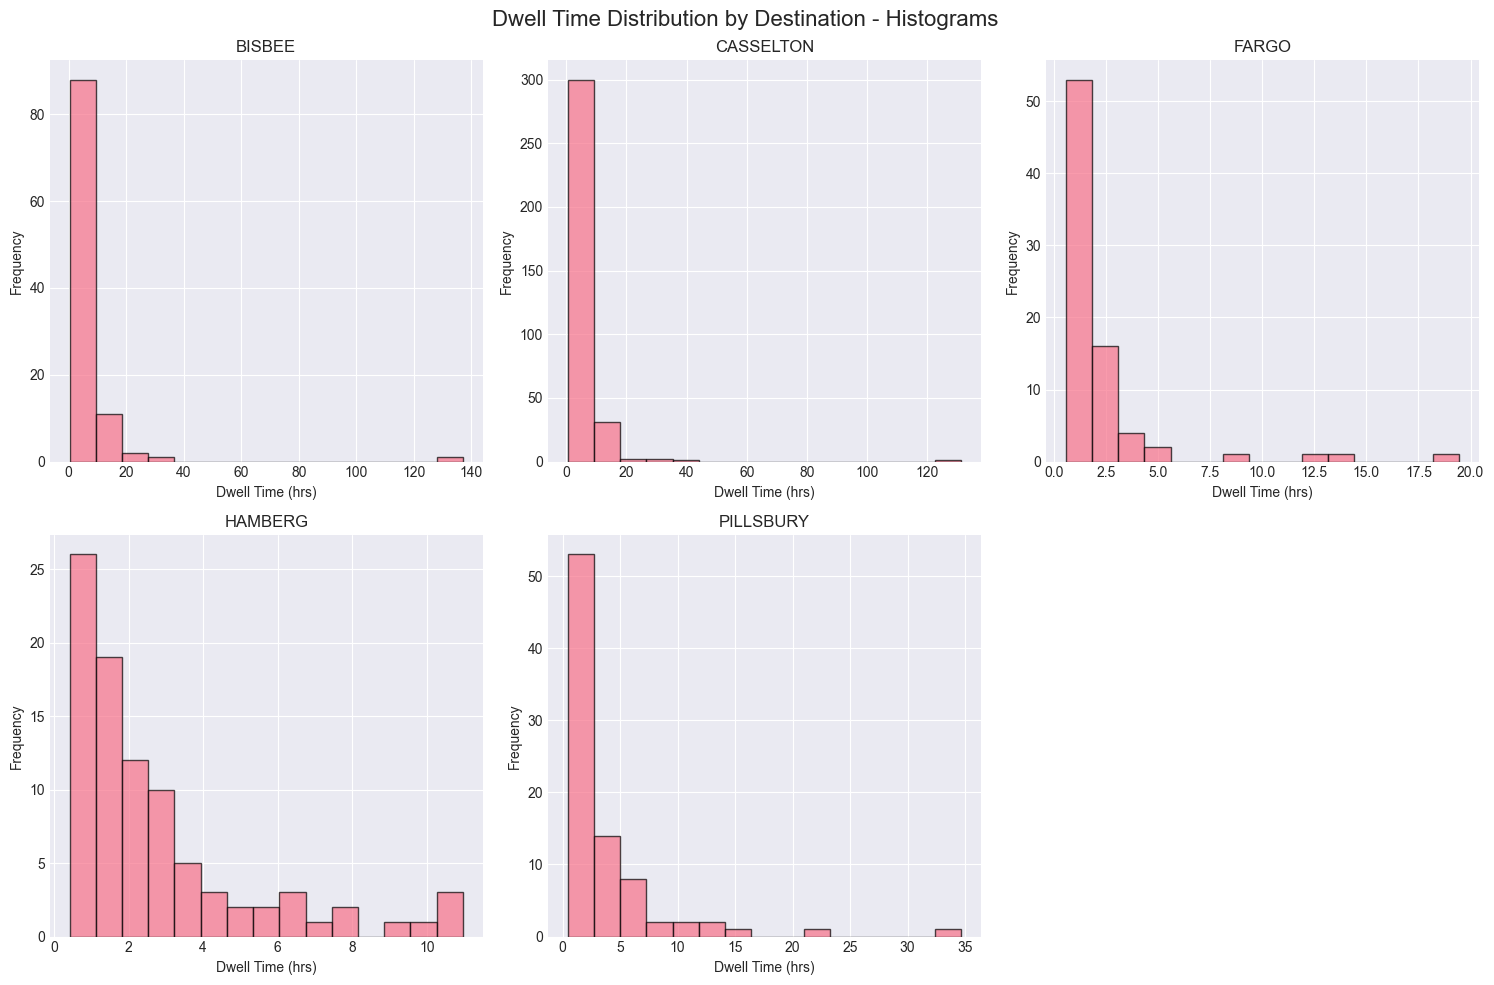

In [ ]:
# Create histograms for dwell time distribution by destination

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

destinations = sorted(df_clean['DESTINATION'].unique())

for idx, dest in enumerate(destinations):
    if idx < len(destinations):
        dest_data = df_clean[df_clean['DESTINATION'] == dest]['DWELL_TIME']
        axes[idx].hist(dest_data, bins=15, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{dest}')
        axes[idx].set_xlabel('Dwell Time (hrs)')
        axes[idx].set_ylabel('Frequency')

# Hide extra subplot
if len(destinations) < 6:
    axes[-1].set_visible(False)

plt.suptitle('Dwell Time Distribution by Destination', fontsize=16)
plt.tight_layout()
plt.show()

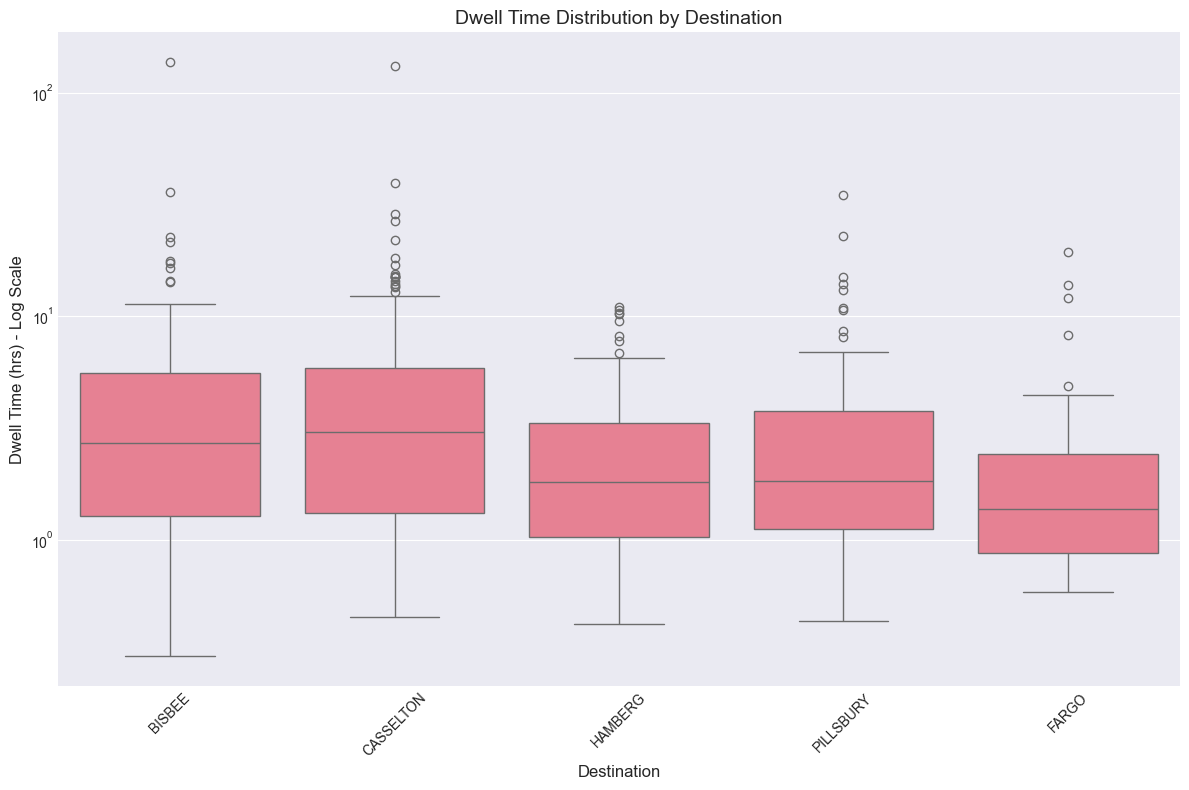

In [ ]:
# Visualize dwell time distribution by destination using boxplot
# With a normal scale the boxes were to squished at the bottom so I used a log scale to better show the distribution despite outliers

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean, x='DESTINATION', y='DWELL_TIME')

# Use log scale for y-axis
plt.yscale('log')

plt.title('Dwell Time Distribution by Destination', fontsize=14)
plt.xlabel('Destination', fontsize=12)
plt.ylabel('Dwell Time (hrs) - Log Scale', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

DWELL_TIME Outlier Removal Summary
IQR Multiplier: 1.5
Q1: 1.13 hours
Q3: 4.90 hours
IQR: 3.77 hours
Lower Bound: -4.52 hours
Upper Bound: 10.55 hours

Original data points: 693
Outliers removed: 50 (7.2%)
Remaining data points: 643


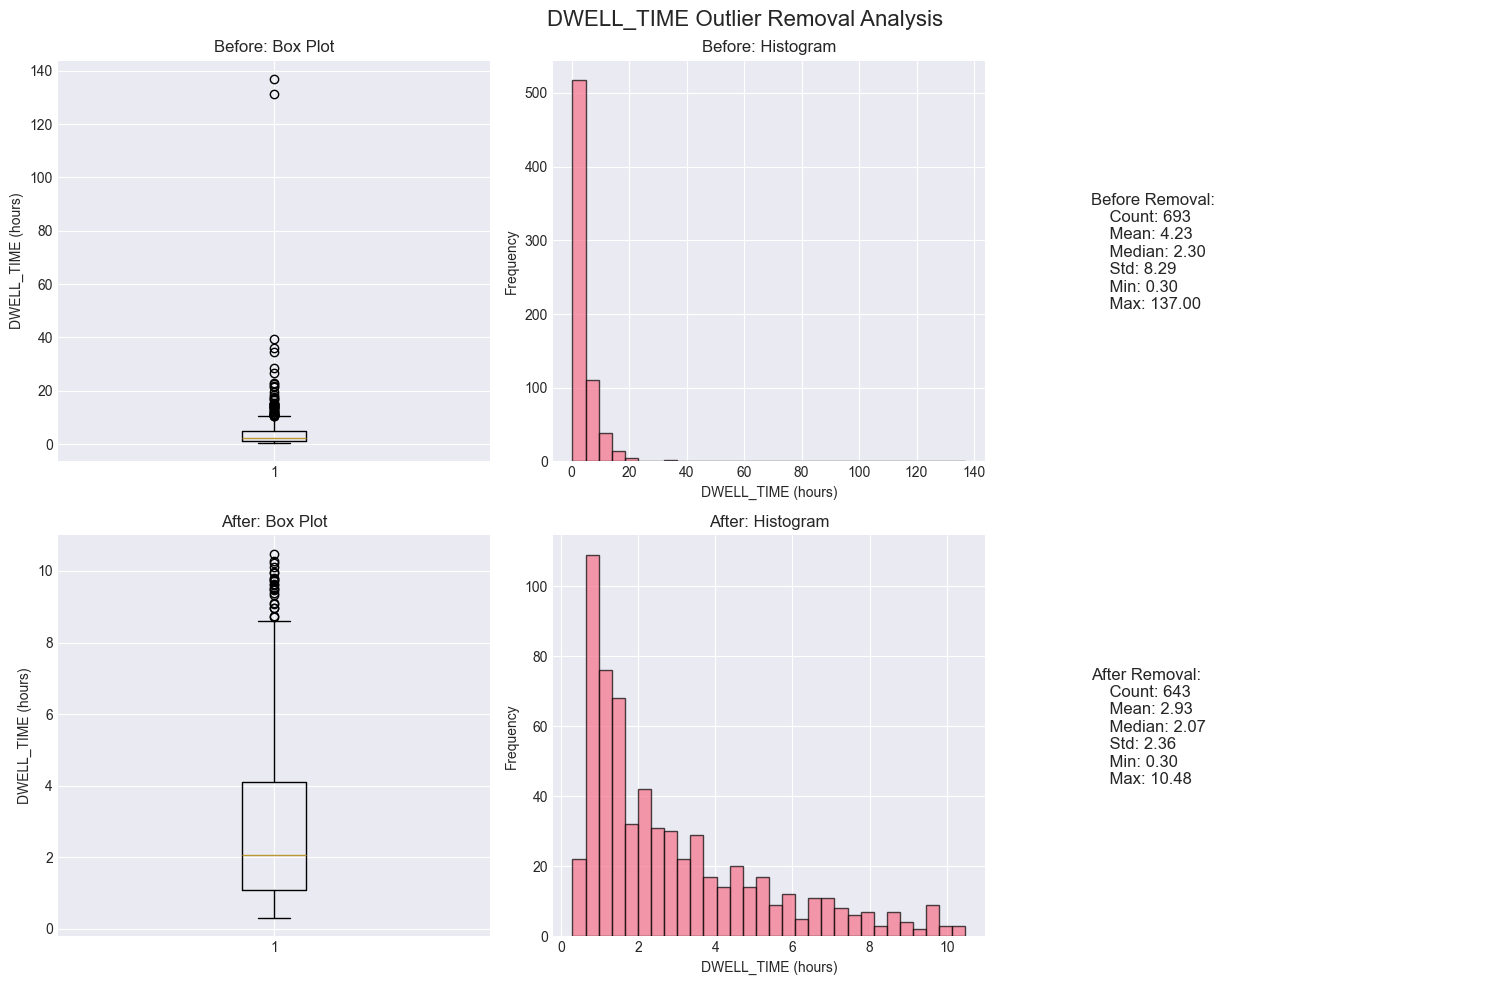

In [ ]:
# First attempt at outlier removal using IQR method
# Even after removing outliers, many points remain above the upper whisker
# IQR method may not be suitable here

def remove_dwell_time_outliers(df, iqr_multiplier=1.5, verbose=True):

    # Calculate IQR
    Q1 = df['DWELL_TIME'].quantile(0.25)
    Q3 = df['DWELL_TIME'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Identify outliers
    outlier_mask = (df['DWELL_TIME'] < lower_bound) | (df['DWELL_TIME'] > upper_bound)
    outlier_indices = df[outlier_mask].index

    # Remove outliers
    df_cleaned = df[~outlier_mask].copy()

    if verbose:
        print("DWELL_TIME Outlier Removal Summary")
        print(f"IQR Multiplier: {iqr_multiplier}")
        print(f"Q1: {Q1:.2f} hours")
        print(f"Q3: {Q3:.2f} hours")
        print(f"IQR: {IQR:.2f} hours")
        print(f"Lower Bound: {lower_bound:.2f} hours")
        print(f"Upper Bound: {upper_bound:.2f} hours")
        print(f"\nOriginal data points: {len(df)}")
        print(f"Outliers removed: {len(outlier_indices)} ({len(outlier_indices)/len(df)*100:.1f}%)")
        print(f"Remaining data points: {len(df_cleaned)}")

    return df_cleaned, outlier_indices

# Visualization function
def visualize_dwell_time_outliers(df_original, df_cleaned):
    """
    Create before/after visualization
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Before - Box plot
    axes[0, 0].boxplot(df_original['DWELL_TIME'])
    axes[0, 0].set_title('Before: Box Plot')
    axes[0, 0].set_ylabel('DWELL_TIME (hours)')

    # Before - Histogram
    axes[0, 1].hist(df_original['DWELL_TIME'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Before: Histogram')
    axes[0, 1].set_xlabel('DWELL_TIME (hours)')
    axes[0, 1].set_ylabel('Frequency')

    # Before - Statistics
    axes[0, 2].axis('off')
    stats_text_before = f"""Before Removal:
    Count: {len(df_original)}
    Mean: {df_original['DWELL_TIME'].mean():.2f}
    Median: {df_original['DWELL_TIME'].median():.2f}
    Std: {df_original['DWELL_TIME'].std():.2f}
    Min: {df_original['DWELL_TIME'].min():.2f}
    Max: {df_original['DWELL_TIME'].max():.2f}
    """
    axes[0, 2].text(0.1, 0.5, stats_text_before, fontsize=12, verticalalignment='center')

    # After - Box plot
    axes[1, 0].boxplot(df_cleaned['DWELL_TIME'])
    axes[1, 0].set_title('After: Box Plot')
    axes[1, 0].set_ylabel('DWELL_TIME (hours)')

    # After - Histogram
    axes[1, 1].hist(df_cleaned['DWELL_TIME'], bins=30, edgecolor='black', alpha=0.7)
    axes[1, 1].set_title('After: Histogram')
    axes[1, 1].set_xlabel('DWELL_TIME (hours)')
    axes[1, 1].set_ylabel('Frequency')

    # After - Statistics
    axes[1, 2].axis('off')
    stats_text_after = f"""After Removal:
    Count: {len(df_cleaned)}
    Mean: {df_cleaned['DWELL_TIME'].mean():.2f}
    Median: {df_cleaned['DWELL_TIME'].median():.2f}
    Std: {df_cleaned['DWELL_TIME'].std():.2f}
    Min: {df_cleaned['DWELL_TIME'].min():.2f}
    Max: {df_cleaned['DWELL_TIME'].max():.2f}
    """
    axes[1, 2].text(0.1, 0.5, stats_text_after, fontsize=12, verticalalignment='center')

    plt.suptitle('DWELL_TIME Outlier Removal Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

# Apply outlier removal
df_no_outliers, outlier_indices = remove_dwell_time_outliers(df_clean, iqr_multiplier=1.5)

# Visualize the results
visualize_dwell_time_outliers(df_clean, df_no_outliers)

# Save cleaned data if needed
#df_no_outliers.to_csv('cleaned_data_no_outliers.csv', index=False)